In [1]:
# Import the modules
import pandas as pd
import hvplot.pandas
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# Read and output the csv
df_movies = pd.read_csv('../DataSets/movies_clean_V2.csv')
df_movies['Year'] = df_movies['Title'].str.extract(r'\((\d{4})\)')
df_movies['Title'] = df_movies['Title'].str.replace(r'\s\(\d{4}\)', '', regex=True)
df_movies.head()

,MovieID,Title,Genres_Western,Genres_War,Genres_Thriller,Genres_Sci-Fi,Genres_Romance,Genres_Mystery,Genres_Musical,Genres_Horror,...,Genres_Fantasy,Genres_Drama,Genres_Documentary,Genres_Crime,Genres_Comedy,Genres_Children's,Genres_Animation,Genres_Adventure,Genres_Action,Year
0,1,Toy Story,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,1995
1,2,Jumanji,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1995
2,3,Grumpier Old Men,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1995
3,4,Waiting to Exhale,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1995
4,5,Father of the Bride Part II,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1995


In [3]:
# Read and output the csv
df_rating = pd.read_csv('../DataSets/ratings_clean.csv')

df_rating.head()

,UserID,MovieID,Rating,Timestamp
0,438,193,4,980904915
1,438,19,1,976258257
2,438,1013,3,981602900
3,438,1954,3,981602012
4,438,1017,3,981602575


In [4]:
# Read and output the csv
df_users = pd.read_csv('../DataSets/users_clean_V2.csv')

df_users.head()

,UserID,Gender,Age,Occupation
0,1,1,1,10
1,2,2,56,16
2,3,2,25,15
3,4,2,45,7
4,5,2,25,20


## Create a Data Base

In [5]:
from sqlalchemy import create_engine
import os

In [6]:
# Define the path
database_path = os.path.join('Resources', 'combined_movies_dataset.sqlite')

# Create a single SQLite database connection
engine = create_engine(f'sqlite:///{database_path}')

# Write each DataFrame to a separate table in the SQLite database
df_movies.to_sql('movies', engine, if_exists='replace', index=False)
df_rating.to_sql('ratings', engine, if_exists='replace', index=False)
df_users.to_sql('users', engine, if_exists='replace', index=False)


6040

In [7]:
# With our three data bases, perform a join
# Define the SQL query to join ratings, movies, and users
query = """
    SELECT 
        r.UserID,
        u.Gender,
        u.Age,
        u.Occupation,
        m.MovieID,
        m.Title,
        m.Year,
        r.Rating,
        m.Genres_Western,
        m.Genres_War,
        m.Genres_Thriller,
        m."Genres_Sci-Fi",
        m.Genres_Romance,
        m.Genres_Mystery,
        m.Genres_Musical,
        m.Genres_Horror,
        m."Genres_Film-Noir",
        m.Genres_Fantasy,
        m.Genres_Drama,
        m.Genres_Documentary,
        m.Genres_Crime,
        m.Genres_Comedy,
        m."Genres_Children's",
        m.Genres_Animation,
        m.Genres_Adventure,
        m.Genres_Action
    FROM ratings r
    JOIN movies m ON r.MovieID = m.MovieID
    JOIN users u ON r.UserID = u.UserID
"""

# Load the result into a pandas DataFrame
df_combined = pd.read_sql(query, engine)


df_combined.head()



,UserID,Gender,Age,Occupation,MovieID,Title,Year,Rating,Genres_Western,Genres_War,...,Genres_Film-Noir,Genres_Fantasy,Genres_Drama,Genres_Documentary,Genres_Crime,Genres_Comedy,Genres_Children's,Genres_Animation,Genres_Adventure,Genres_Action
0,438,2,18,11,193,Showgirls,1995,4,0,0,...,0,0,1,0,0,0,0,0,0,0
1,438,2,18,11,19,Ace Ventura,None,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,438,2,18,11,1013,"Parent Trap, The",1961,3,0,0,...,0,0,1,0,0,0,1,0,0,0
3,438,2,18,11,1954,Rocky,1976,3,0,0,...,0,0,1,0,0,0,0,0,0,1
4,438,2,18,11,1017,Swiss Family Robinson,1960,3,0,0,...,0,0,0,0,0,0,1,0,1,0


In [8]:
df_no_title = df_combined.drop("MovieID", axis=1)
df_ratings_3_and_up = df_no_title[df_no_title['Rating'] >= 3]
df_ratings_3_and_up_no_year = df_ratings_3_and_up.drop("Year", axis=1)
df_ratings_3_and_up_no_year.set_index("Title", inplace=True)

# Do with Rating.
# Data we're training with
# Scoring
# Filter with and without

In [9]:
df_ratings_3_and_up_no_year.to_csv("../df_ratings.csv")

In [10]:
# Number of entries
df_combined.shape


(1000208, 26)

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, silhouette_score

In [12]:
# Create a list to store inertia values
inertia = []

# Create a list to store the values of k
k = range(2, 11)

In [13]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the spread_df DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(df_ratings_3_and_up_no_year)
    inertia.append(k_model.inertia_)

In [14]:
# Create a Dictionary that holds the list values for k and inertia
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame using the elbow_data Dictionary
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,2.501483e+12
1,2,6.148918e+11
2,3,2.827156e+11
3,4,1.579956e+11
4,5,9.950286e+10


In [15]:
# Plot the DataFrame
df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)

:Curve   [k]   (inertia)

In [60]:
# Use the same loop as above with your own data
k_values = range(2, 100)
scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_ratings_3_and_up_no_year)
    score = calinski_harabasz_score(df_ratings_3_and_up_no_year, kmeans.labels_)
    scores.append(score)

In [61]:
# Select the best k based on the highest Calinski-Harabasz score
best_k = k_values[scores.index(max(scores))]
print(f"Best number of clusters (k) based on Calinski-Harabasz score: {best_k}")

Best number of clusters (k) based on Calinski-Harabasz score: 97


In [62]:
# Inference and Prediction with best K
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(df_ratings_3_and_up_no_year)

# Assign clusters to data
df_ratings_3_and_up_no_year['cluster'] = kmeans.labels_

In [63]:
# Count the number of records in each cluster
cluster_counts = df_ratings_3_and_up_no_year['cluster'].value_counts()
print("Record count per cluster:")
print(cluster_counts)

Record count per cluster:
cluster
45    16949
18    14912
42    13842
2     13230
10    12620
      ...  
95     5359
26     5301
7      4863
96     4647
9      4586
Name: count, Length: 97, dtype: int64


In [64]:
# Align clusters with the dataset: Add cluster labels to the original data
df_ratings_3_and_up_no_year['Cluster_Label'] = kmeans.labels_

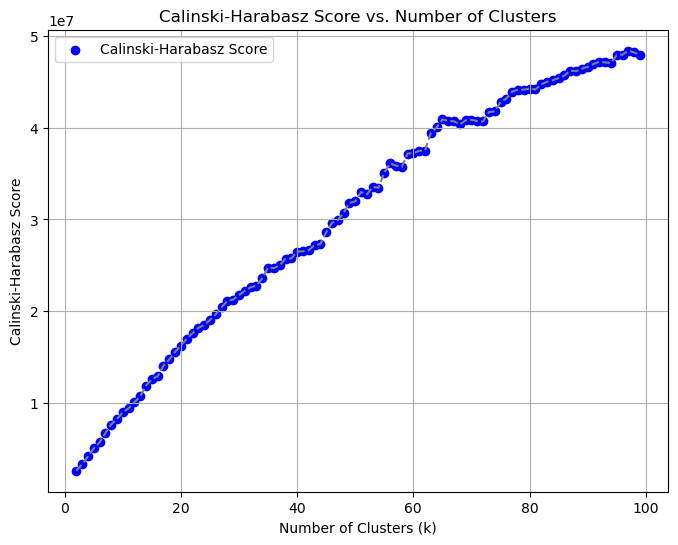

In [65]:
# Plot the Calinski-Harabasz scores
plt.figure(figsize=(8, 6))
plt.scatter(k_values, scores, color='blue', marker='o', label='Calinski-Harabasz Score')
plt.plot(k_values, scores, linestyle='--', color='gray')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

In [66]:
# Use the same loop as above with your own data
k_values = range(101, 200)
scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_ratings_3_and_up_no_year)
    score = calinski_harabasz_score(df_ratings_3_and_up_no_year, kmeans.labels_)
    scores.append(score)

In [67]:
# Select the best k based on the highest Calinski-Harabasz score
best_k_101 = k_values[scores.index(max(scores))]
print(f"Best number of clusters (k) based on Calinski-Harabasz score: {best_k_101}")

Best number of clusters (k) based on Calinski-Harabasz score: 135


In [68]:
# Inference and Prediction with best K
kmeans = KMeans(n_clusters=best_k_101, random_state=0)
kmeans.fit(df_ratings_3_and_up_no_year)

# Assign clusters to data
df_ratings_3_and_up_no_year['cluster_101'] = kmeans.labels_

In [69]:
# Count the number of records in each cluster
cluster_counts = df_ratings_3_and_up_no_year['cluster_101'].value_counts()
print("Record count per cluster:")
print(cluster_counts)

Record count per cluster:
cluster_101
27    11646
49    10953
77    10794
14    10760
29    10755
      ...  
1      3411
97     3352
30     3234
41     3055
59     2607
Name: count, Length: 135, dtype: int64


In [70]:
# Align clusters with the dataset: Add cluster labels to the original data
df_ratings_3_and_up_no_year['Cluster_Label_101'] = kmeans.labels_

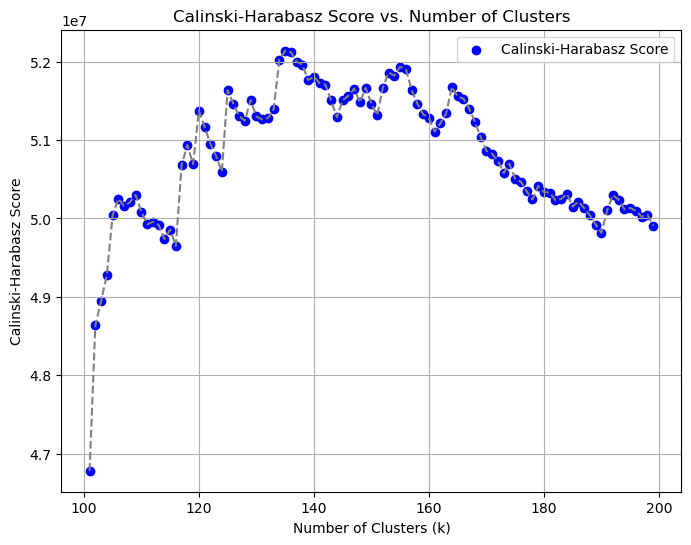

In [71]:
# Plot the Calinski-Harabasz scores
plt.figure(figsize=(8, 6))
plt.scatter(k_values, scores, color='blue', marker='o', label='Calinski-Harabasz Score')
plt.plot(k_values, scores, linestyle='--', color='gray')

# Add labels and title
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score vs. Number of Clusters')
plt.grid(True)
plt.legend()
plt.show()

In [72]:
df_ratings_3_and_up_no_year.head()

,UserID,Gender,Age,Occupation,Rating,Genres_Western,Genres_War,Genres_Thriller,Genres_Sci-Fi,Genres_Romance,...,Genres_Crime,Genres_Comedy,Genres_Children's,Genres_Animation,Genres_Adventure,Genres_Action,cluster,Cluster_Label,cluster_101,Cluster_Label_101
Title,,,,,,,,,,,,,,,,,,,,,
Showgirls,438,2,18,11,4,0,0,0,0,0,...,0,0,0,0,0,0,65,65,88,88
"Parent Trap, The",438,2,18,11,3,0,0,0,0,0,...,0,0,1,0,0,0,65,65,88,88
Rocky,438,2,18,11,3,0,0,0,0,0,...,0,0,0,0,0,1,65,65,88,88
Swiss Family Robinson,438,2,18,11,3,0,0,0,0,0,...,0,0,1,0,1,0,65,65,88,88
"20,000 Leagues Under the Sea",438,2,18,11,3,0,0,0,1,0,...,0,0,1,0,1,0,65,65,88,88


In [74]:
df_ratings_3_and_up_no_year_cluster_135 = df_ratings_3_and_up_no_year.drop("cluster", axis=1)
df_ratings_3_and_up_no_year_cluster_135 = df_ratings_3_and_up_no_year_cluster_135.drop("Cluster_Label", axis=1)
df_ratings_3_and_up_no_year_cluster_135 = df_ratings_3_and_up_no_year_cluster_135.drop("cluster_101", axis=1)

In [75]:
df_ratings_3_and_up_no_year_cluster_135.head()

,UserID,Gender,Age,Occupation,Rating,Genres_Western,Genres_War,Genres_Thriller,Genres_Sci-Fi,Genres_Romance,...,Genres_Fantasy,Genres_Drama,Genres_Documentary,Genres_Crime,Genres_Comedy,Genres_Children's,Genres_Animation,Genres_Adventure,Genres_Action,Cluster_Label_101
Title,,,,,,,,,,,,,,,,,,,,,
Showgirls,438,2,18,11,4,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,88
"Parent Trap, The",438,2,18,11,3,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,88
Rocky,438,2,18,11,3,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,88
Swiss Family Robinson,438,2,18,11,3,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,88
"20,000 Leagues Under the Sea",438,2,18,11,3,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,88


In [76]:
df_ratings_3_and_up_no_year_cluster_135.to_csv("../df_ratings_cluster_135.csv")